In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

In [104]:
def plot_gray_image(image, title=None):
    plt.figure(figsize=(15, 7), dpi=100)
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Подготовка данных

In [145]:
def load_and_display_image(image_path, display=True):
    """
    Loads an image from a file path, displays it using matplotlib, and returns it.

    Args:
        image_path: The path to the image file.
        display: Disply the image if True.

    Returns:
        A NumPy array representing the loaded image, or None if the image cannot be loaded or is invalid.
        Prints an informative error message if something goes wrong.
    """

    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Error: Could not load image from {image_path}.")
            return None

        if display:
            plot_gray_image(img)

        return img


    except Exception as e:
        print(f"An error occurred: {e}")
        return None

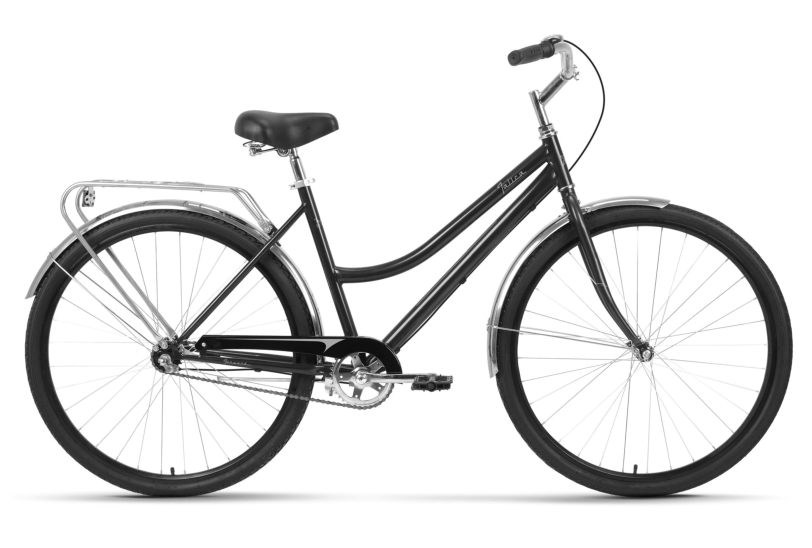

In [106]:
test_image_path = 'src/test.jpg'
test_image = load_and_display_image(test_image_path)

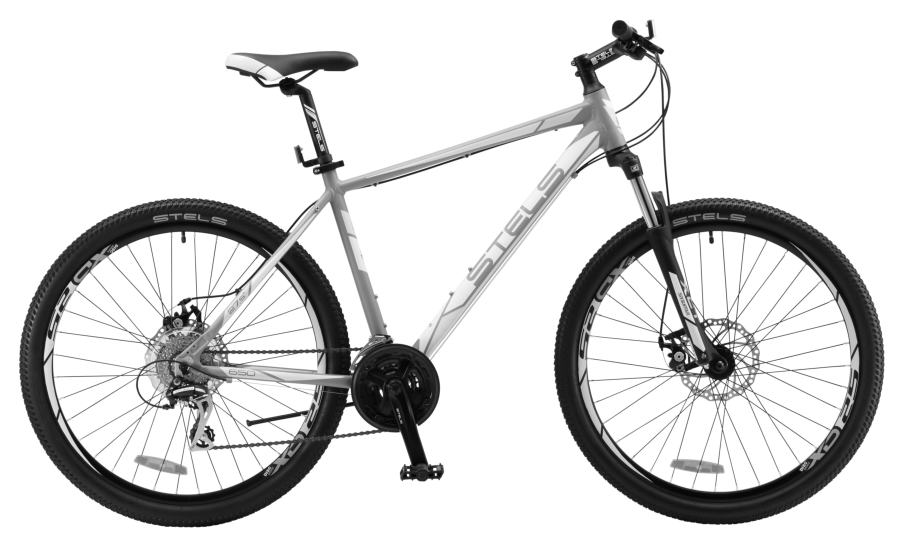

In [107]:
train_image_path = 'src/train.jpg'
train_image = load_and_display_image(train_image_path)

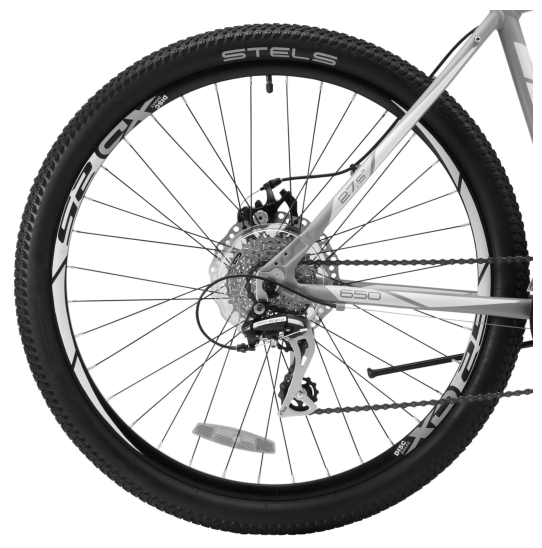

In [108]:
left_wheel_image_path = 'src/left_wheel.jpg'
left_wheel_image = load_and_display_image(left_wheel_image_path)

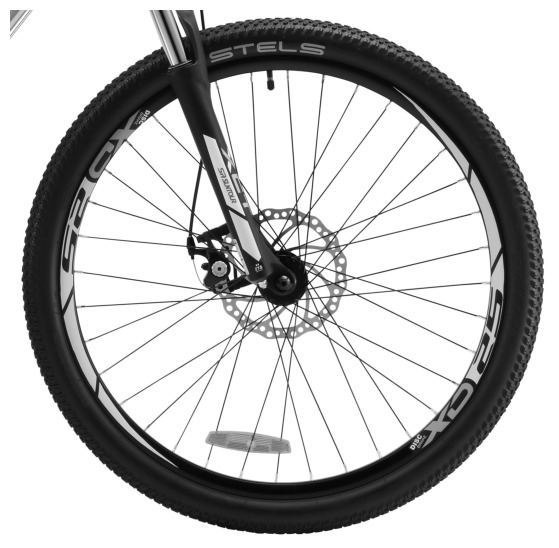

In [109]:
right_wheel_image_path = 'src/right_wheel.jpg'
right_wheel_image = load_and_display_image(right_wheel_image_path)

# Размещение деталей

In [149]:
def find_location(img, template, display=True):
    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
    print("Top left point:", top_left)
    print("Bottom right point:", bottom_right)
    img_copy = img.copy()
    cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
    if display:
        plot_gray_image(img_copy)
    return top_left, bottom_right

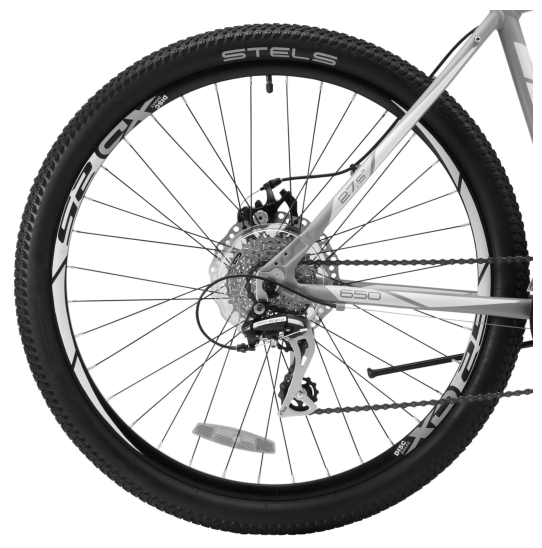

In [111]:
left_wheel_image_path = 'src/left_wheel.jpg'
left_wheel_image = load_and_display_image(left_wheel_image_path)

Top left point: (40, 1074)
Bottom right point: (2047, 3104)


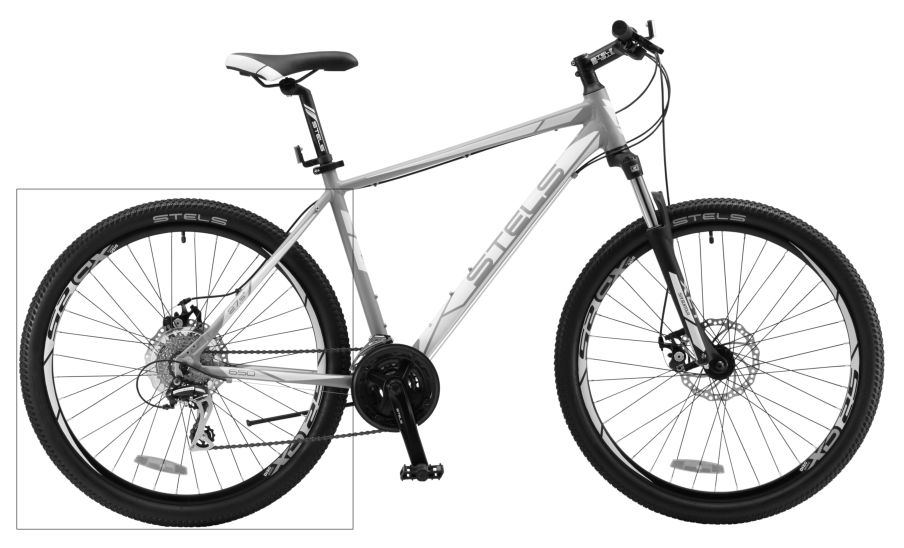

In [112]:
tl_pnt_left_wheel, br_pnt_left_wheel = find_location(train_image, left_wheel_image)

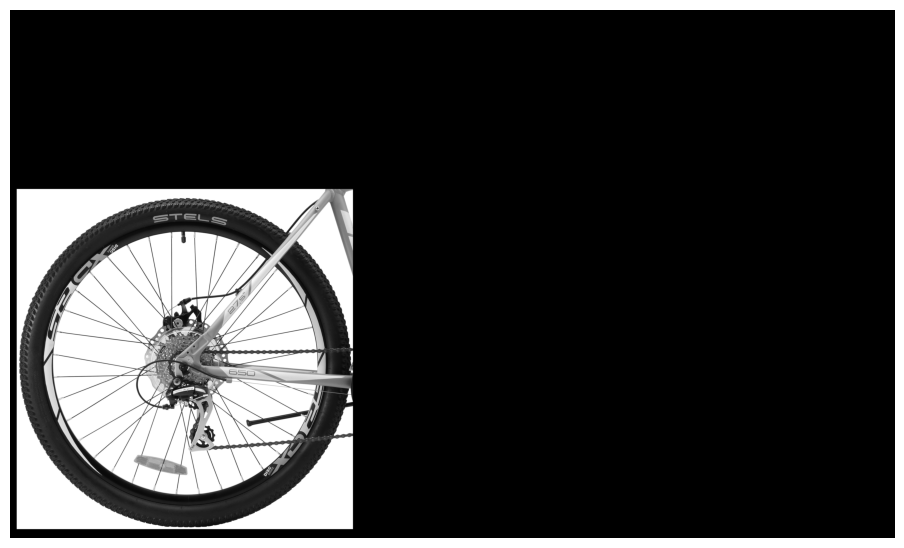

In [113]:
left_wheel_full_image = np.zeros_like(train_image)
left_wheel_full_image[tl_pnt_left_wheel[1]:br_pnt_left_wheel[1], 
                      tl_pnt_left_wheel[0]:br_pnt_left_wheel[0]] = left_wheel_image

plot_gray_image(left_wheel_full_image)

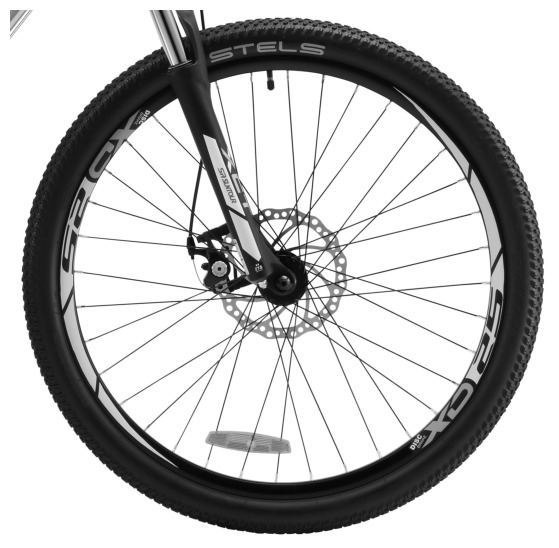

In [114]:
right_wheel_image_path = 'src/right_wheel.jpg'
right_wheel_image = load_and_display_image(right_wheel_image_path)

Top left point: (3202, 1094)
Bottom right point: (5242, 3091)


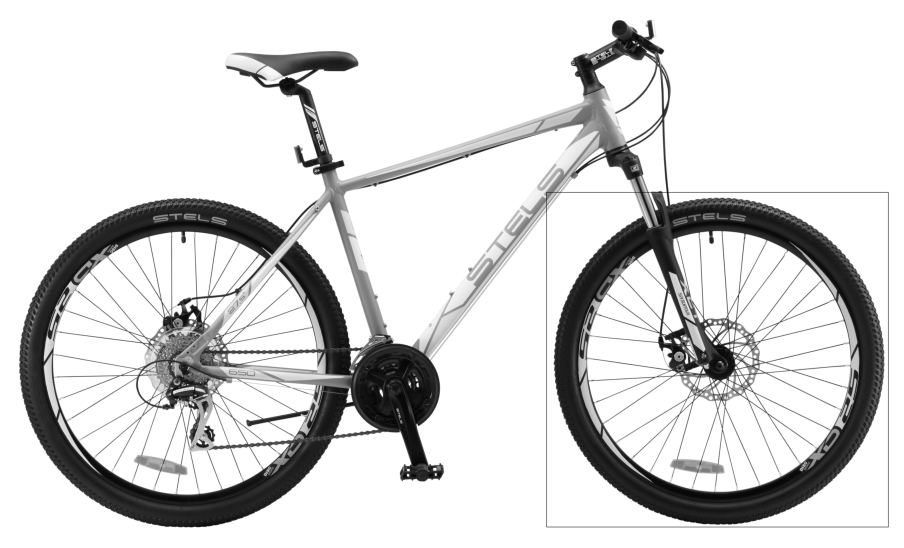

In [115]:
tl_pnt_right_wheel, br_pnt_right_wheel = find_location(train_image, right_wheel_image)

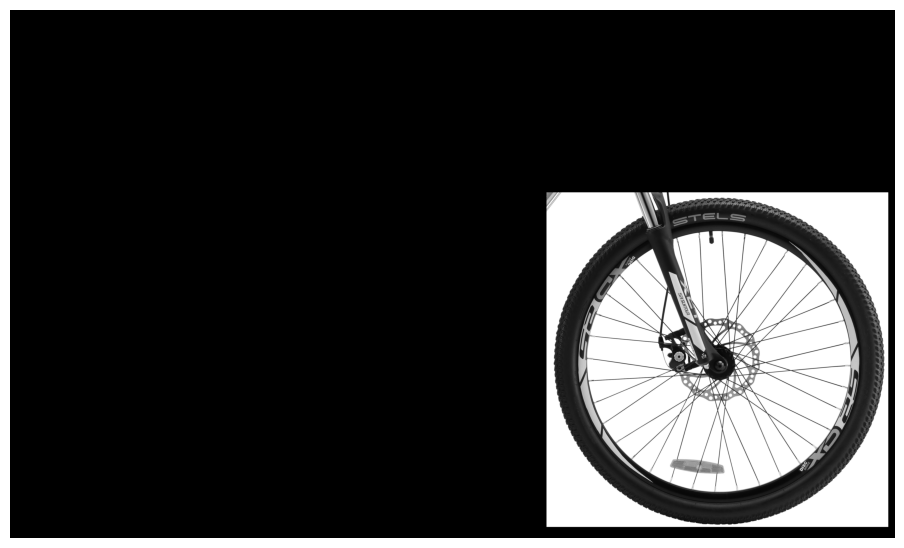

In [116]:
right_wheel_full_image = np.zeros_like(train_image)
right_wheel_full_image[tl_pnt_right_wheel[1]:br_pnt_right_wheel[1], 
                      tl_pnt_right_wheel[0]:br_pnt_right_wheel[0]] = right_wheel_image

plot_gray_image(right_wheel_full_image)

# Resize train изображений

In [117]:
print("Size of test image:", test_image.shape)
print("Size of train image:", train_image.shape)

Size of test image: (1280, 1920)
Size of train image: (3157, 5282)


In [118]:
scaling_factor = 0.35
new_dimensions = (int(train_image.shape[1] * scaling_factor), int(train_image.shape[0] * scaling_factor))

In [119]:
train_image = cv2.resize(train_image, new_dimensions, interpolation=cv2.INTER_AREA)
print("New size of train image:", train_image.shape)

New size of train image: (1104, 1848)


In [120]:
left_wheel_full_image = cv2.resize(left_wheel_full_image, new_dimensions, interpolation=cv2.INTER_AREA)
right_wheel_full_image = cv2.resize(right_wheel_full_image, new_dimensions, interpolation=cv2.INTER_AREA)

# Получение HOG

In [121]:
def extract_hog_features(image, plot=False):
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(12, 12),
                    cells_per_block=(2, 2), visualize=True)

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

        ax1.axis('off')
        ax1.imshow(image, cmap=plt.cm.gray)
        ax1.set_title('Input image')

        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        ax2.axis('off')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('Histogram of Oriented Gradients')
        plt.show()
    
    return fd, hog_image

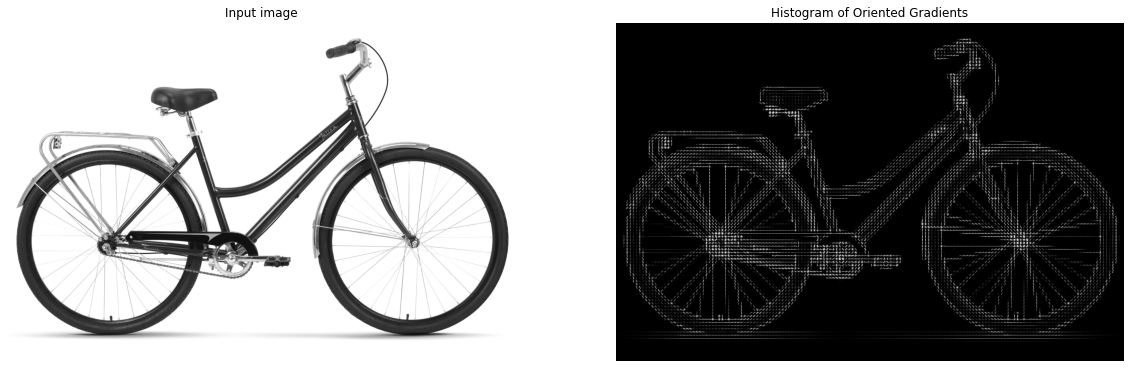

(1280, 1920)


In [122]:
test_fd, test_hog_image = extract_hog_features(test_image, True)
print(test_hog_image.shape)

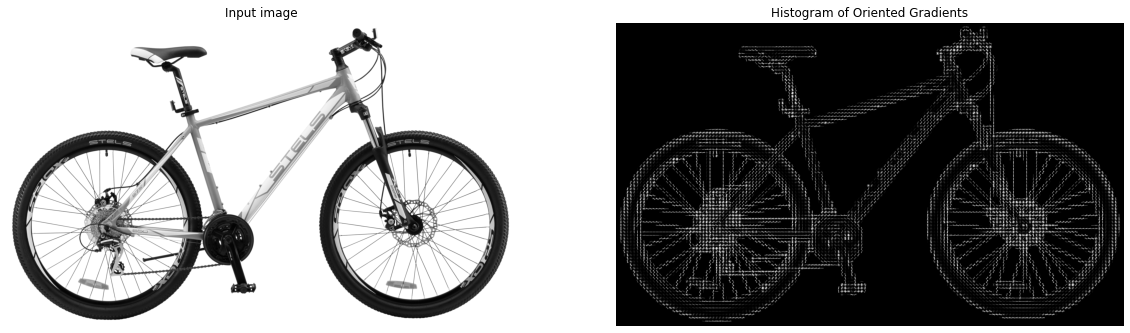

(1104, 1848)


In [123]:
train_fd, train_hog_image = extract_hog_features(train_image, True)
print(train_hog_image.shape)

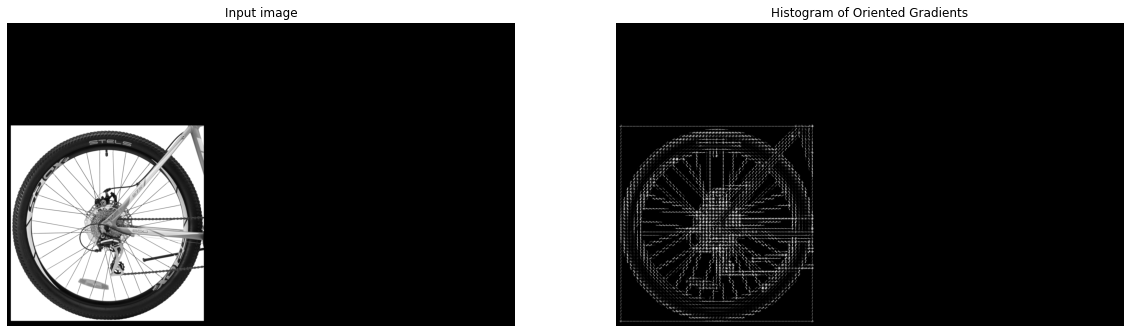

In [124]:
left_wheel_fd, left_wheel_hog_image = extract_hog_features(left_wheel_full_image, True)

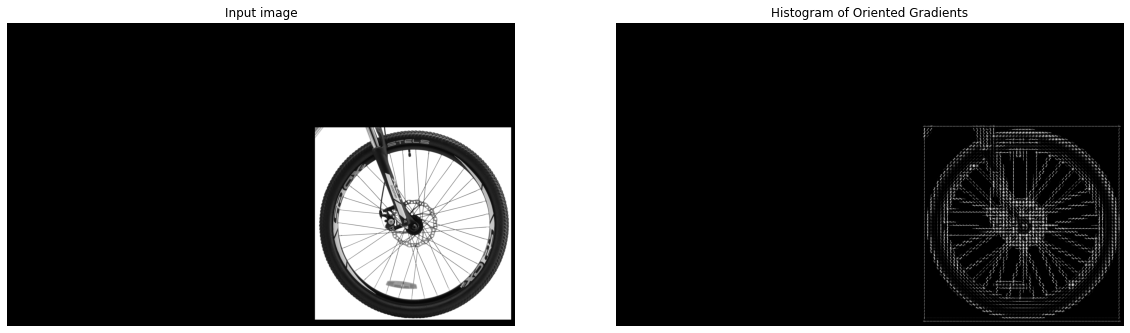

In [125]:
right_wheel_fd, right_wheel_hog_image = extract_hog_features(right_wheel_full_image, True)

# Поиск с использованием коэффициента

In [126]:
def find_hog_location(img_hog, template_hog):
    img_hog = img_hog.astype(np.uint8)
    template_hog = template_hog.astype(np.uint8)
    
    res = cv2.matchTemplate(img_hog, template_hog, cv2.TM_CCOEFF_NORMED)
    
    return res

In [127]:
def plot_best_match(res, image, template):
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    top_left = max_loc
    bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
    
    img_copy = image.copy()
    cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
    plot_gray_image(img_copy)

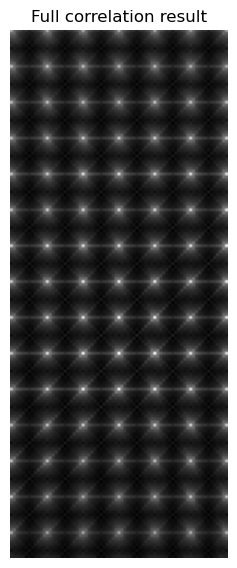

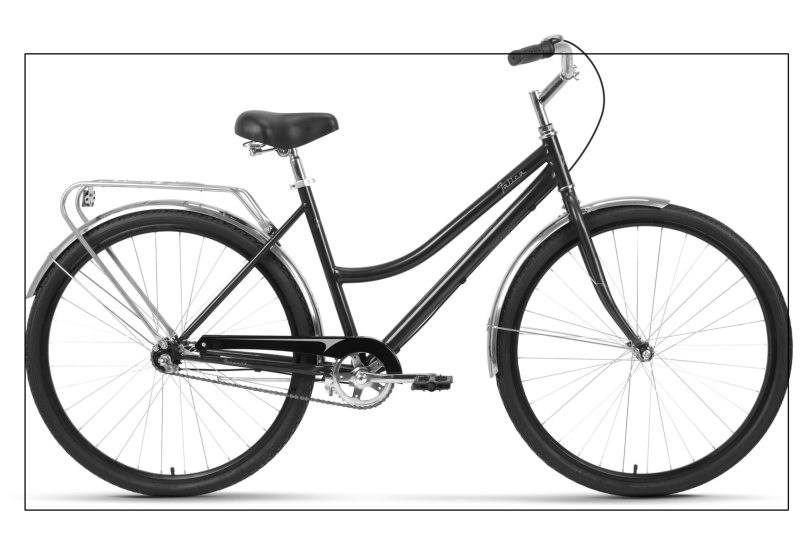

Max value = 0.28146333


In [128]:
full_corr_res = find_hog_location(test_hog_image, train_hog_image)
plot_gray_image(full_corr_res, "Full correlation result")
plot_best_match(full_corr_res, test_image, train_image)
print("Max value =", np.max(full_corr_res))

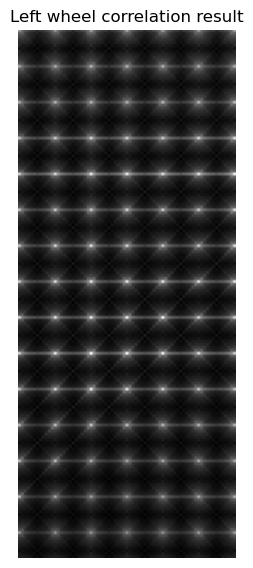

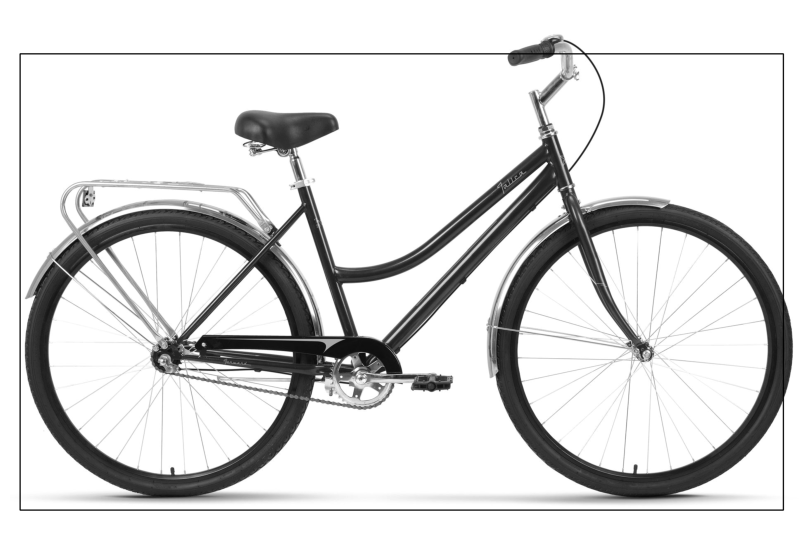

Max value = 0.21877755


In [129]:
left_wheel_corr_res = find_hog_location(test_hog_image, left_wheel_hog_image)
plot_gray_image(left_wheel_corr_res, "Left wheel correlation result")
plot_best_match(left_wheel_corr_res, test_image, train_image)
print("Max value =", np.max(left_wheel_corr_res))

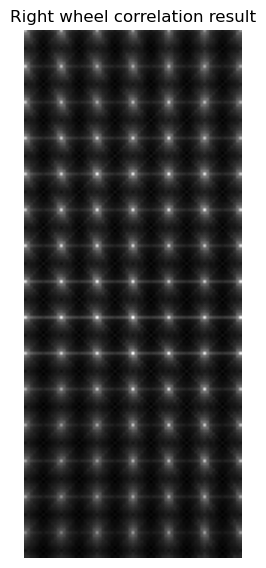

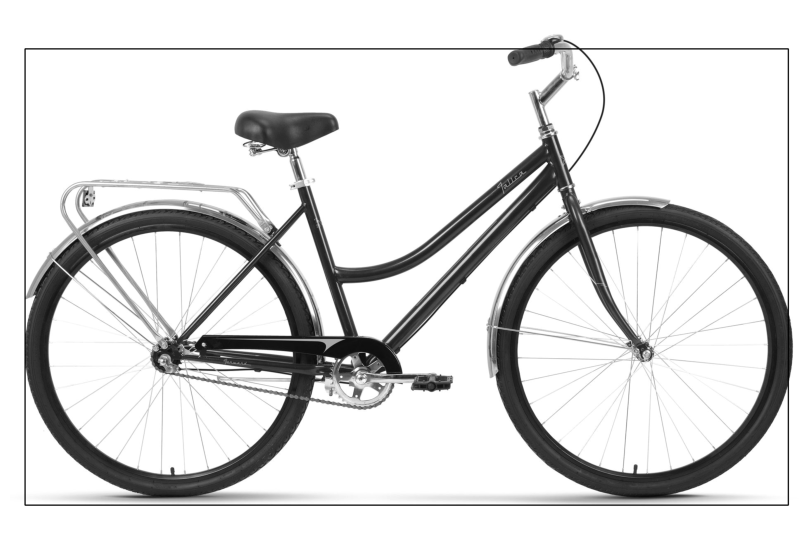

Max value = 0.1472204


In [130]:
right_wheel_corr_res = find_hog_location(test_hog_image, right_wheel_hog_image)
plot_gray_image(right_wheel_corr_res, "Right wheel correlation result")
plot_best_match(right_wheel_corr_res, test_image, train_image)
print("Max value =", np.max(right_wheel_corr_res))

In [131]:
details_count = 2
alpha = 1 / details_count

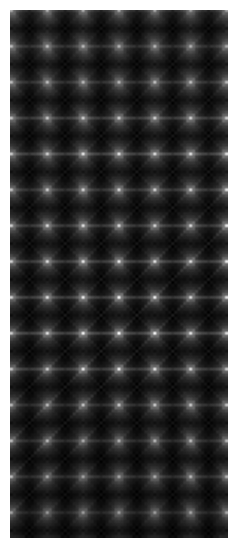

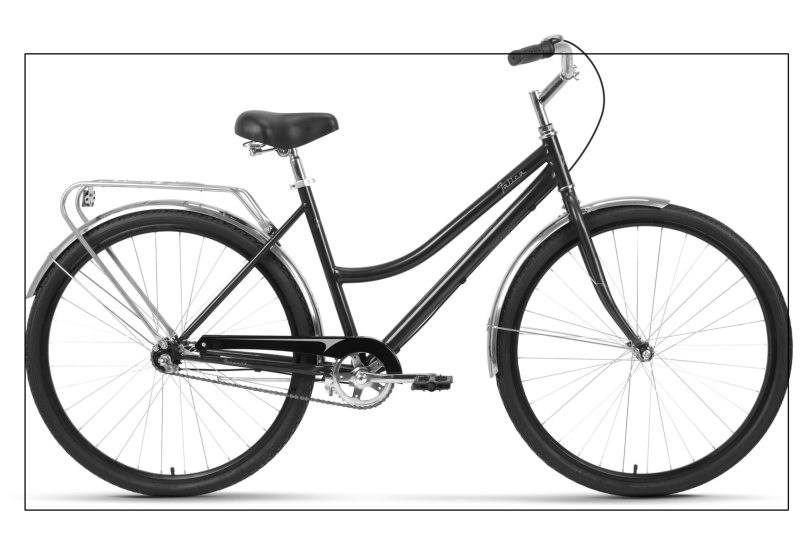

Max value = 0.23082998


In [132]:
res = full_corr_res + alpha * (left_wheel_corr_res + right_wheel_corr_res)
res /= 2 # Normalization

plot_gray_image(res)
plot_best_match(res, test_image, train_image)
print("Max value =", np.max(res))

# Гауссовское размытие

In [133]:
def create_gaussian_mask_cv2(image, center_x, center_y, sigma, amplitude=1.0):
    """Creates a Gaussian mask using OpenCV.

    Args:
        image: The input image (NumPy array).  Should be a grayscale image (or you'll need to convert it).
        center_x: x-coordinate of the Gaussian center.
        center_y: y-coordinate of the Gaussian center.
        sigma: Standard deviation (controls blur).
        amplitude: Maximum value in the mask (default is 1.0, for a normalized mask).

    Returns:
        A NumPy array representing the Gaussian mask.  Data type is float64.
    """
    rows, cols = image.shape[:2]  # Get image dimensions
    y, x = np.mgrid[0:rows, 0:cols]  # Create a coordinate grid
    gauss = amplitude * np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))
    return gauss

In [143]:
def get_top_10(full_corr_res):
    full_corr_res_flat = full_corr_res.flatten()

    # Get indices of 10 largest values in the flattened array
    top_10_flat_indices = np.argsort(full_corr_res_flat)[-10:][::-1]

    # Convert flat indices back to 2D indices
    row_indices = top_10_flat_indices // full_corr_res.shape[1]  # Integer division
    col_indices = top_10_flat_indices % full_corr_res.shape[1]   # Modulo operation

    top_10_res_indices = np.column_stack((row_indices, col_indices))
    return top_10_res_indices

In [144]:
top_10_res_indices = get_top_10(full_corr_res)
print(top_10_res_indices)

[[108  36]
 [108  48]
 [ 96  36]
 [120  36]
 [108  24]
 [ 96  48]
 [120  24]
 [120  48]
 [ 84  36]
 [ 72  72]]


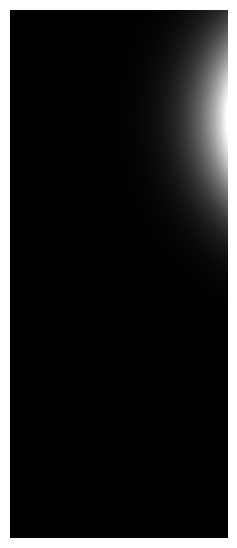

In [135]:
wheel_mask = create_gaussian_mask_cv2(full_corr_res, top_10_res_indices[0][0], top_10_res_indices[0][1], sigma=20)
plot_gray_image(wheel_mask)

In [169]:
def find_most_fitted_point(top_10_res_indices, full_corr_res, left_wheel_corr_res, right_wheel_corr_res):
    the_largest_value = -1
    best_point = None
    for x, y in top_10_res_indices:
        wheel_mask = create_gaussian_mask_cv2(full_corr_res, x, y, sigma=100)
        right_wheel_corr_res *= wheel_mask
        left_wheel_corr_res *= wheel_mask
        res = full_corr_res + right_wheel_corr_res + left_wheel_corr_res
        res /= 3 # Normalization

        max_value = np.max(res)
        if max_value > the_largest_value:
            the_largest_value = max_value
            best_point = x, y
    return the_largest_value, best_point

In [136]:
the_largest_value, best_point = find_most_fitted_point(top_10_res_indices, full_corr_res, right_wheel_corr_res, left_wheel_corr_res)
print(the_largest_value)

0.26578304


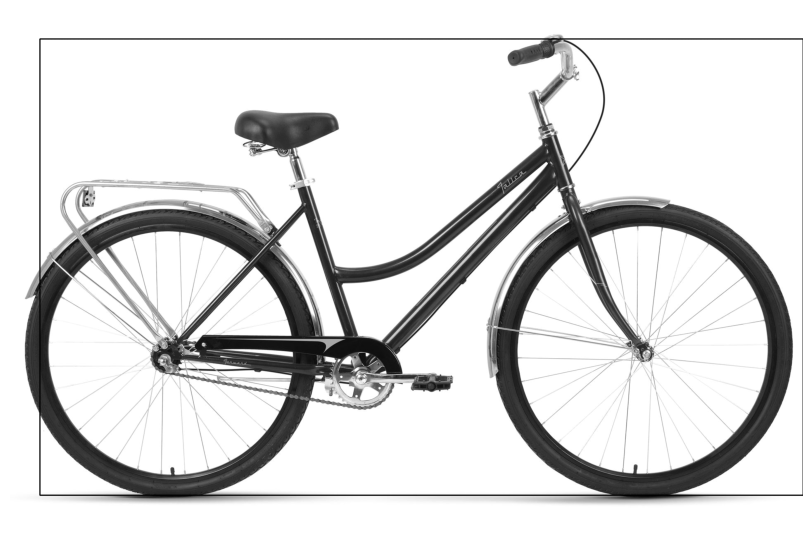

In [146]:
top_left = x, y
bottom_right = (top_left[0] + train_image.shape[1], top_left[1] + train_image.shape[0])
    
img_copy = test_image.copy()
cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
plot_gray_image(img_copy)

# Весь пайплайн

In [342]:
# Read images
test_image_path = 'src/test.jpg'
test_image = load_and_display_image(test_image_path, False)

train_image_path = 'src/train.jpg'
train_image = load_and_display_image(train_image_path, False)

lw_image_path = 'src/left_wheel.jpg'
lw_image = load_and_display_image(lw_image_path, False)

rw_image_path = 'src/right_wheel.jpg'
rw_image = load_and_display_image(rw_image_path, False)

In [343]:
# Resize train to the test size
source_height, source_width = train_image.shape[:2]
target_height, target_width = test_image.shape[:2]

# Calculate the scaling factors
width_ratio = target_width / source_width
height_ratio = target_height / source_height
scaling_factor = min(width_ratio, height_ratio)

new_width = int(source_width * scaling_factor)
new_height = int(source_height * scaling_factor)
print("New dimensions:", new_height, new_width)

train_image = cv2.resize(train_image, (new_width, new_height))

# Only wheels for final demonstration
lw_new_width = int(lw_image.shape[1] * scaling_factor)
lw_new_height = int(lw_image.shape[0] * scaling_factor)
lw_image = cv2.resize(lw_image, (lw_new_width, lw_new_height))

rw_new_width = int(rw_image.shape[1] * scaling_factor)
rw_new_height = int(rw_image.shape[0] * scaling_factor)
rw_image = cv2.resize(rw_image, (rw_new_width, rw_new_height))

New dimensions: 1147 1920


In [344]:
# Make wheel masks
tl_pnt_lw, br_pnt_lw = find_location(train_image, lw_image, False)
lw_full_image = np.zeros_like(train_image)
lw_full_image[tl_pnt_lw[1]:br_pnt_lw[1], 
              tl_pnt_lw[0]:br_pnt_lw[0]] = lw_image

tl_pnt_rw, br_pnt_rw = find_location(train_image, rw_image, False)
rw_full_image = np.zeros_like(train_image)
rw_full_image[tl_pnt_rw[1]:br_pnt_rw[1], 
              tl_pnt_rw[0]:br_pnt_rw[0]] = rw_image

Top left point: (15, 390)
Bottom right point: (744, 1127)
Top left point: (1164, 398)
Bottom right point: (1905, 1123)


In [345]:
# Calculate HOG of the test
_, test_hog_image = extract_hog_features(test_image)

In [346]:
max_res = 0
best_size = None
best_scale = None
best_point = None
scale_count = 10

# Details
best_lw_point = None
best_lw_size = 0

best_rw_point = None
best_rw_size = 0

best_full_img_point = None

for scale_factor in range(4, scale_count):
    # Resize
    scale = 1 / (scale_count - scale_factor)
    new_dimensions = (int(train_image.shape[1] * scale), int(train_image.shape[0] * scale))
    train_img = cv2.resize(train_image.copy(), new_dimensions, interpolation=cv2.INTER_AREA)
    lw_full_image = cv2.resize(lw_full_image.copy(), new_dimensions, interpolation=cv2.INTER_AREA)
    rw_full_image = cv2.resize(rw_full_image.copy(), new_dimensions, interpolation=cv2.INTER_AREA)    
    print("New size of train image:", train_img.shape)
    
    # Hogs
    _, train_hog_img = extract_hog_features(train_img)
    _, left_wheel_hog_img = extract_hog_features(lw_full_image)
    _, right_wheel_hog_img = extract_hog_features(rw_full_image)
    
    # Correlation
    full_corr_res = find_hog_location(test_hog_image, train_hog_img)
    lw_corr_res = find_hog_location(test_hog_image, left_wheel_hog_img)
    rw_corr_res = find_hog_location(test_hog_image, right_wheel_hog_img)
    print(full_corr_res.shape, lw_corr_res.shape, rw_corr_res.shape)
    
    # The best point
    top_10_res_indices = get_top_10(full_corr_res)
    res, point = find_most_fitted_point(top_10_res_indices, full_corr_res, lw_corr_res, rw_corr_res)
    print("Max value =", res)
    
    if res > max_res:
        max_res = res
        best_size = new_dimensions
        best_point = point
        best_scale = scale
        
        _, _, _, best_lw_point = cv2.minMaxLoc(lw_corr_res)
        _, _, _, best_rw_point = cv2.minMaxLoc(rw_corr_res)
        _, _, _, best_full_img_point = cv2.minMaxLoc(full_corr_res)

New size of train image: (191, 320)
(1090, 1601) (1090, 1601) (1090, 1601)
Max value = 0.15129575
New size of train image: (229, 384)
(1052, 1537) (1052, 1537) (1052, 1537)
Max value = 0.12717532
New size of train image: (286, 480)
(995, 1441) (995, 1441) (995, 1441)
Max value = 0.11790646
New size of train image: (382, 640)
(899, 1281) (899, 1281) (899, 1281)
Max value = 0.11055589
New size of train image: (573, 960)
(708, 961) (708, 961) (708, 961)
Max value = 0.07314942
New size of train image: (1147, 1920)
(134, 1) (134, 1) (134, 1)
Max value = 0.1662821


In [347]:
print(f"Best point:{best_point}, best_size:{best_size}, best scale: {best_scale}")

Best point:(72, 0), best_size:(1920, 1147), best scale: 1.0


In [348]:
# Prepare wheels parameters
best_lw_size = np.array((lw_image.shape[1] * best_scale, lw_image.shape[0] * best_scale), dtype=np.uint64)
best_rw_size = np.array((rw_image.shape[1] * best_scale, rw_image.shape[0] * best_scale), dtype=np.uint64)

# Top left point if wheels on source image considering scale
tl_pnt_lw = np.array(tl_pnt_lw, dtype=np.uint64) * int(best_scale)
tl_pnt_rw = np.array(tl_pnt_rw, dtype=np.uint64) * int(best_scale)

# Convert to np.arrays
best_lw_point = np.array(best_lw_point, dtype=np.uint64)
best_lw_size = np.array(best_lw_size, dtype=np.uint64)

best_rw_point = np.array(best_rw_point, dtype=np.uint64)
best_rw_size = np.array(best_rw_size, dtype=np.uint64)

best_full_img_point = np.array(best_full_img_point, dtype=np.uint64)
best_size = np.array(best_size, dtype=np.uint64)
best_point = np.array(best_point, dtype=np.uint64)

In [349]:
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_GRAY2RGB)

In [350]:
# Plot main results
top_left = best_point
bottom_right = top_left + best_size
    
img_copy = test_image_rgb.copy()
cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
None

In [351]:
# Plot wheels
top_left_lw = best_lw_point + tl_pnt_lw
bottom_right_lw = top_left_lw + best_lw_size 
cv2.rectangle(img_copy, top_left_lw, bottom_right_lw, (255, 0, 0), 2)

top_left_rw = best_rw_point + tl_pnt_rw
bottom_right_rw = top_left_rw + best_rw_size  
cv2.rectangle(img_copy, top_left_rw, bottom_right_rw, (255, 0, 0), 2)

# Plot only bike correlation
top_left = best_full_img_point
bottom_right = top_left + best_size
cv2.rectangle(img_copy, top_left, bottom_right, (0, 0, 255), 2)
None

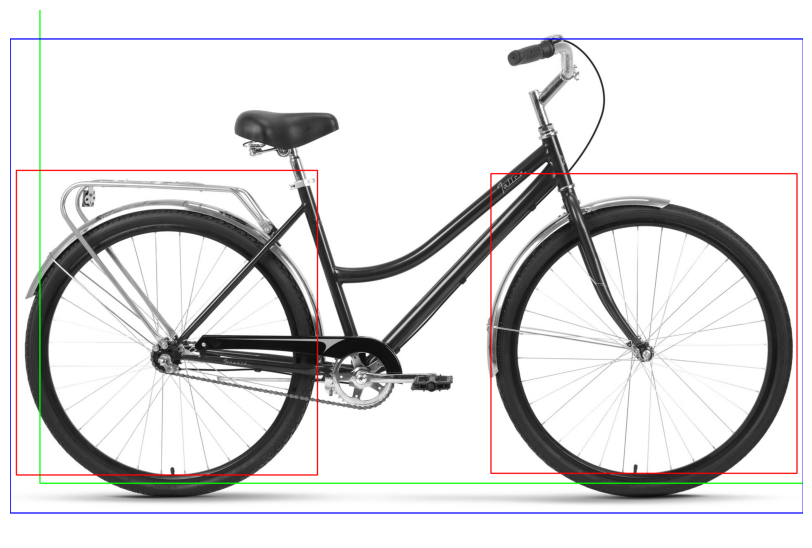

In [352]:
plot_gray_image(img_copy)